# Initialize

In [5]:
%load_ext autoreload
%autoreload 2

#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

import torch
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch import nn

import sys
sys.path.append('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders')


from AE.models import AE_0, ProgressiveAE
from AE.train import train, layer_wise_pretrain_load_dict, train_ProgressiveAE
from AE.datasets import MNISTDigit2Dataset, MNIST_digit2_translated_dataset, MNISTDigit2OnlyDataset
from AE.plotter_functions import plot_original_vs_decoded

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR

#–––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––


# if torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Utilizzo Apple Silicon GPU (MPS)")
# elif torch.cuda.is_available():
#     device = torch.device("cuda")
#     print("Utilizzo NVIDIA GPU (CUDA)")
# else:
#     device = torch.device("cpu")
#     print("Utilizzo la CPU")

device = torch.device("cpu")  # Fallback to CPU if no GPU is available

SEED = 42
torch.manual_seed(SEED)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Datasets


In [2]:
batch_size = 64


train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )




dataset_2MNIST_train = MNISTDigit2Dataset(train=True, download=True, target_size=60000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
train_loader_2MNIST = DataLoader(dataset_2MNIST_train, batch_size=batch_size, shuffle=True)

batch_images, batch_labels = next(iter(train_loader_2MNIST))
print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")

print("\n––––––––––––––––––––––––––––––––––––––––––––––––––––––\n")

dataset_2MNIST_val = MNISTDigit2Dataset(train=False, download=True, target_size=10000)
print(f"Dataset size: {len(dataset_2MNIST_train)}")
print(f"Image shape: {dataset_2MNIST_train[0][0].shape}")
print(f"Label: {dataset_2MNIST_train[0][1]}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")
val_loader_2MNIST = DataLoader(dataset_2MNIST_val, batch_size=batch_size, shuffle=True)

print(f"Batch images shape: {batch_images.shape}")
print(f"Batch labels shape: {batch_labels.shape}")
print(f"All labels are 2: {torch.all(batch_labels == 2)}")



datasets = ["MNIST", "EMNIST", "2MNIST"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNIST": train_loader_2MNIST
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNIST": val_loader_2MNIST
}

Found 5958 original samples of digit '2'
Generated 60000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True

––––––––––––––––––––––––––––––––––––––––––––––––––––––

Found 1032 original samples of digit '2'
Generated 10000 augmented samples
Dataset size: 60000
Image shape: torch.Size([1, 28, 28])
Label: 2
All labels are 2: True
Batch images shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])
All labels are 2: True


In [6]:
batch_size = 64


train_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_MNIST = torch.utils.data.DataLoader(
    datasets.MNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



train_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_EMNIST = torch.utils.data.DataLoader(
    datasets.EMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        split='balanced',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )




dataset_2MNISTonly_train = MNISTDigit2OnlyDataset(train=True, download=True)
train_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_train, batch_size=batch_size, shuffle=True)

dataset_2MNISTonly_val = MNISTDigit2OnlyDataset(train=False, download=True)
val_loader_2MNISTonly = DataLoader(dataset_2MNISTonly_val, batch_size=batch_size, shuffle=True)




datasets = ["MNIST", "EMNIST", "2MNISTonly"]
train_loaders = {
    "MNIST": train_loader_MNIST,
    "EMNIST": train_loader_EMNIST,
    "2MNISTonly": train_loader_2MNISTonly
}
val_loaders = {
    "MNIST": val_loader_MNIST,
    "EMNIST": val_loader_EMNIST,
    "2MNISTonly": val_loader_2MNISTonly
}

Found 5958 samples of digit '2'
Found 1032 samples of digit '2'



## FashionMNIST


In [ ]:

train_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=True,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=True
    )

val_loader_FashionMNIST = torch.utils.data.DataLoader(
    datasets.FashionMNIST(
        '/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data',
        train=False,
        download=True,
        transform=transforms.ToTensor()
        ),
    batch_size=batch_size,
    shuffle=False
    )



## OTHERS


In [ ]:
from AE.datasets import Dataset_HFM, Dataset_pureHFM

batch_size = 64




## train over pureHFM

dataset_HFM_train = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_pureHFM = DataLoader(
    dataset_HFM_train,
    batch_size=batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_pureHFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM/512features/glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_pureHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=batch_size,
    shuffle=False
)
## train over expandedHFM
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM = DataLoader(
    dataset_HFM_train,
    batch_size=batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/16_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=batch_size,
    shuffle=False
)
## train over expandedHFM 32-1024
dataset_HFM_train = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_train60000.pt',
                        root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

train_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_train,
    batch_size=batch_size,
    shuffle=True
)

dataset_HFM_val = Dataset_HFM(csv_file='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/expandedHFM/32_1024features/2hl_glog2_validation10000.pt',
                            root_dir='/Users/enricofrausin/Programmazione/PythonProjects/Fisica/data/pureHFM')

val_loader_expandedHFM_32_1024 = DataLoader(
    dataset_HFM_val, # Importante: usa dataset_HFM_val qui, non dataset_HFM
    batch_size=batch_size,
    shuffle=False
)


# Simultaneous train


## 20 features

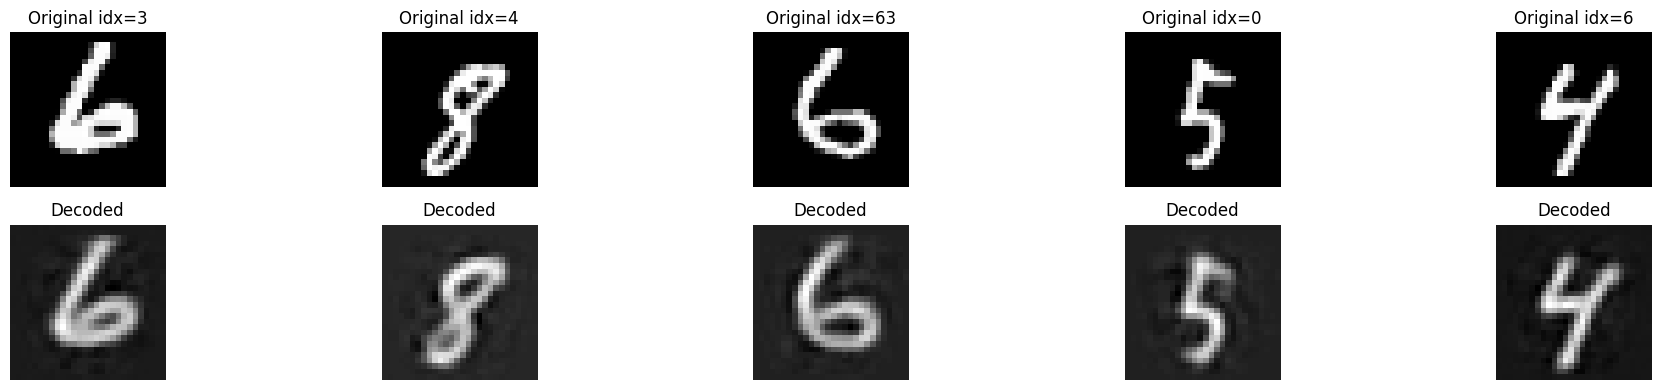

In [36]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)

ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))

plot_original_vs_decoded(ex_model, train_loader, device, num_samples=5, EMNIST=False)

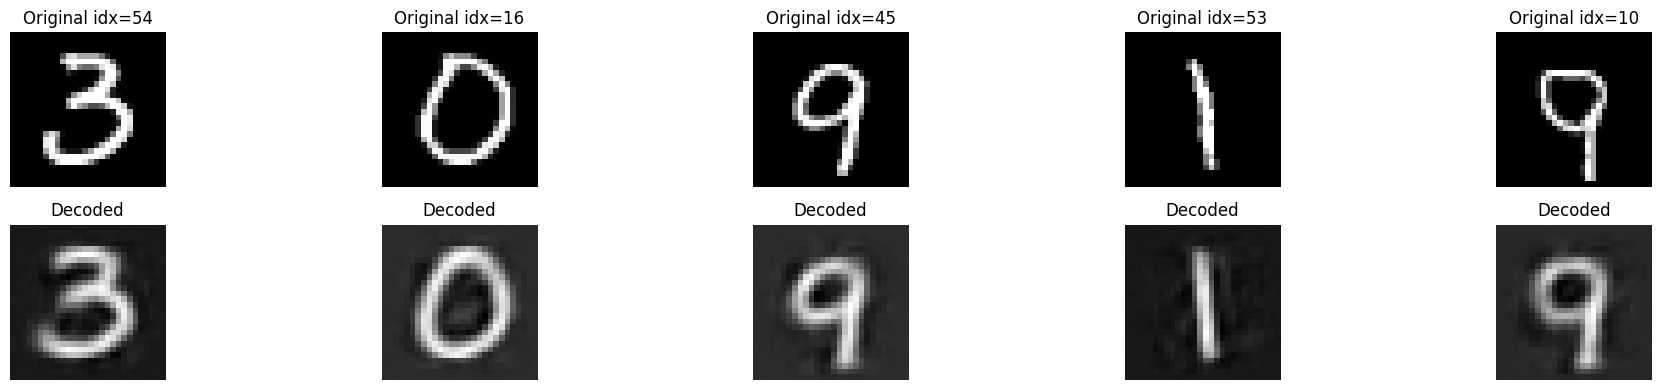

In [33]:
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

plot_original_vs_decoded(ex_model, train_loader, device, num_samples=5, EMNIST=False)

In [27]:
print("\n--------------------------------")
print("TRAINING ON EMNIST")
print("--------------------------------\n")
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784


learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))

# 8 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld20_dr07_lr1e3_lwpretrain_8hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))



print("\n--------------------------------")
print("TRAINING ON MNIST")
print("--------------------------------\n")
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))

# 8 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld20_dr07_lr1e3_lwpretrain_8hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))



print("\n--------------------------------")
print("TRAINING ON 2MNIST")
print("--------------------------------\n")
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784


learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_7hl.pth', map_location=device))

# 8 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=8, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld20_dr07_lr1e3_lwpretrain_8hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld20_dr07_lr1e3_lwpretrain_8hl.pth', map_location=device))



--------------------------------
TRAINING ON EMNIST
--------------------------------



KeyboardInterrupt: 

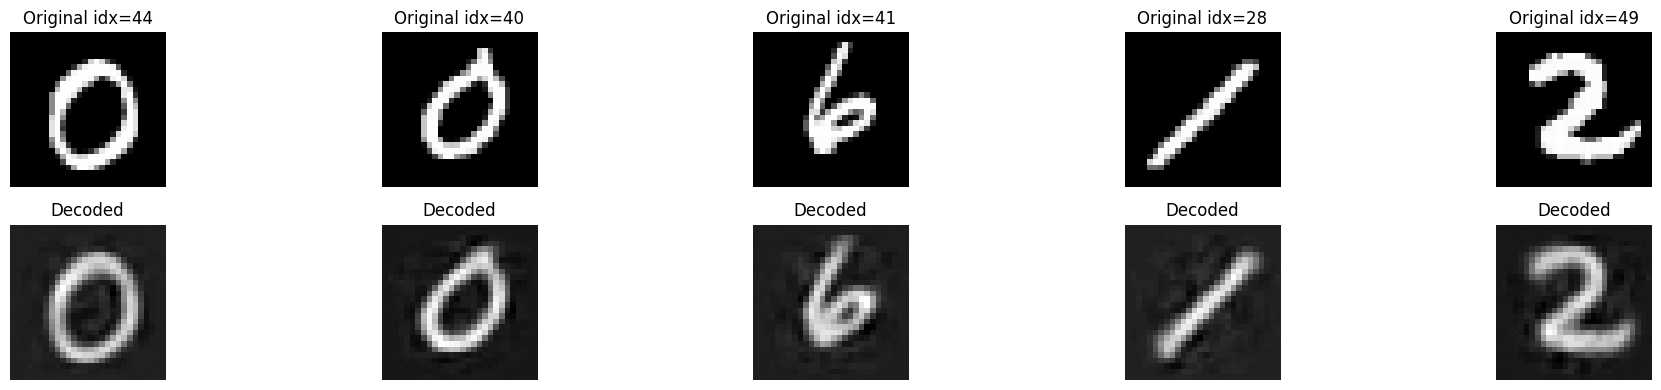

In [23]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784


ex_model = AE_0(input_dim=input_dim, latent_dim=20, decrease_rate=0.7, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)

ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld20_dr07_lr1e3_lwpretrain_3hl.pth', map_location=device))

plot_original_vs_decoded(ex_model, train_loader, device, num_samples=5, EMNIST=False)

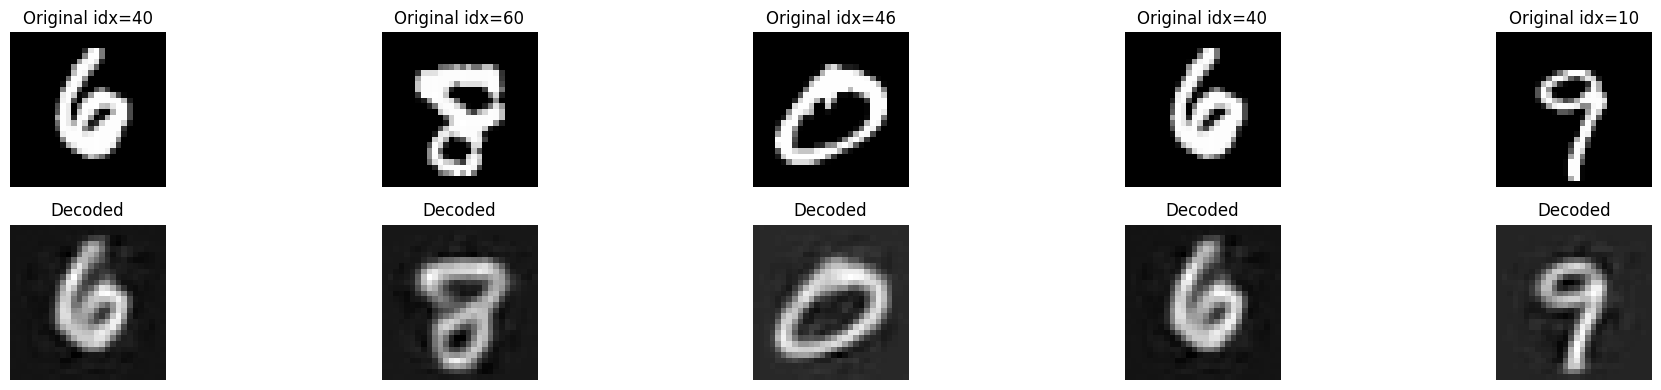

In [48]:
plot_original_vs_decoded(ex_model, train_loader, device, num_samples=5, EMNIST=False)


## EMNIST


In [6]:
train_loader = train_loader_EMNIST
val_loader = val_loader_EMNIST
input_dim = 784


### 6 features

In [37]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld6_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006671493084018006, Validation loss: 0.0006706287850566367
Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 


### 8 features


In [11]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth')

# 2 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth')

# 3 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth')

# 4 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth')


Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 11/15, Average loss: 0.0006
Epoch: 12/15, Average loss: 0.0006
Epoch: 13/15, Average loss: 0.0006
Epoch: 14/15, Average loss: 0.0006
Training completed. Final training loss: 0.0005579704764556695, Validation loss: 0.0005586765916582118
Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 

#### lw pretrain

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld8_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 11/15, Average loss: 0.0006
Epoch: 12/15, Average loss: 0.0006
Epoch: 13/15, Average loss: 0.0006
Epoch: 14/15, Average loss: 0.0006
Training completed. Final training loss: 0.000555559009105522, Validation loss: 0.0005578385744283491
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 1

<All keys matched successfully>

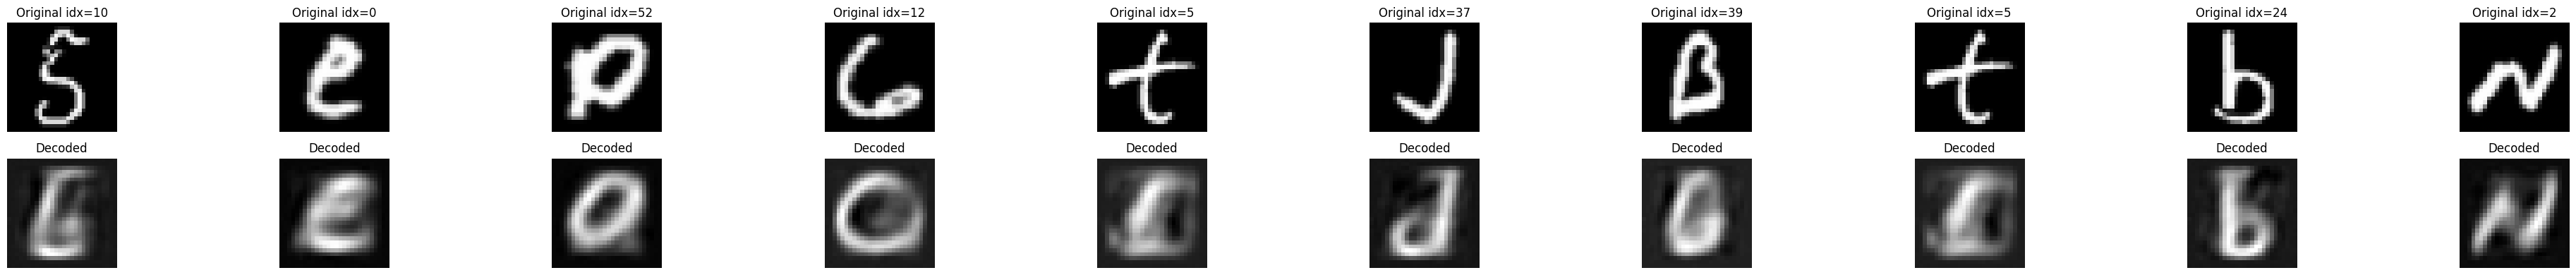

In [31]:
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

plot_original_vs_decoded(new_model, train_loader, device, num_samples=10, EMNIST=True)

### 10 features


In [59]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/EMNIST/ld10_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/EMNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 11/15, Average loss: 0.0005
Epoch: 12/15, Average loss: 0.0005
Epoch: 13/15, Average loss: 0.0005
Epoch: 14/15, Average loss: 0.0005
Training completed. Final training loss: 0.0004879725108365693, Validation loss: 0.0004913068522124531
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 

<All keys matched successfully>

### 20 features


## MNIST

In [3]:
train_loader = train_loader_MNIST
val_loader = val_loader_MNIST
input_dim = 784

### 6 features

In [47]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld6_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0004
Training completed. Final training loss: 0.0004458057051834961, Validation loss: 0.00044437530282884837
Epoch: 0/15, Average loss: 0.0005
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch:

<All keys matched successfully>

### 8 features

In [6]:
learning_rate = 1e-3
weight_decay = 1e-5


# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/prova/MNIST/ld8_dr06_lr1e3_30ep_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=30)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/prova/MNIST/ld8_dr06_lr1e3_30ep_3hl.pth')


Epoch: 0/30, Average loss: 0.0008
Epoch: 1/30, Average loss: 0.0006
Epoch: 2/30, Average loss: 0.0005
Epoch: 3/30, Average loss: 0.0005
Epoch: 4/30, Average loss: 0.0004
Epoch: 5/30, Average loss: 0.0004
Epoch: 6/30, Average loss: 0.0004
Epoch: 7/30, Average loss: 0.0004
Epoch: 8/30, Average loss: 0.0004
Epoch: 9/30, Average loss: 0.0004
Epoch: 10/30, Average loss: 0.0004
Epoch: 11/30, Average loss: 0.0004
Epoch: 12/30, Average loss: 0.0004
Epoch: 13/30, Average loss: 0.0004
Epoch: 14/30, Average loss: 0.0004
Epoch: 15/30, Average loss: 0.0004
Epoch: 16/30, Average loss: 0.0004
Epoch: 17/30, Average loss: 0.0003
Epoch: 18/30, Average loss: 0.0003
Epoch: 19/30, Average loss: 0.0003
Epoch: 20/30, Average loss: 0.0003
Epoch: 21/30, Average loss: 0.0003
Epoch: 22/30, Average loss: 0.0003
Epoch: 23/30, Average loss: 0.0003
Epoch: 24/30, Average loss: 0.0003
Epoch: 25/30, Average loss: 0.0003
Epoch: 26/30, Average loss: 0.0003
Epoch: 27/30, Average loss: 0.0003
Epoch: 28/30, Average loss: 0.

#### layer-wise pretraining

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0005
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0004
Training completed. Final training loss: 0.00038860385194420817, Validation loss: 0.00038361831456422803
Epoch: 0/15, Average loss: 0.0005
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0003
Epoch: 5/15, Average loss: 0.0003
Epoch: 6/15, Average loss: 0.0003
Epoch: 7/15, Average loss: 0.0003
Epoch: 8/15, Average loss: 0.0003
Epoch: 9/15, Average loss: 0.0003
Epoch: 10/15, Average loss: 0.0003
Epoch

In [9]:
learning_rate = 1e-3
weight_decay = 1e-5

ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))


# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0004
Training completed. Final training loss: 0.00038005521170174085, Validation loss: 0.0003919882113113999
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch:

<All keys matched successfully>

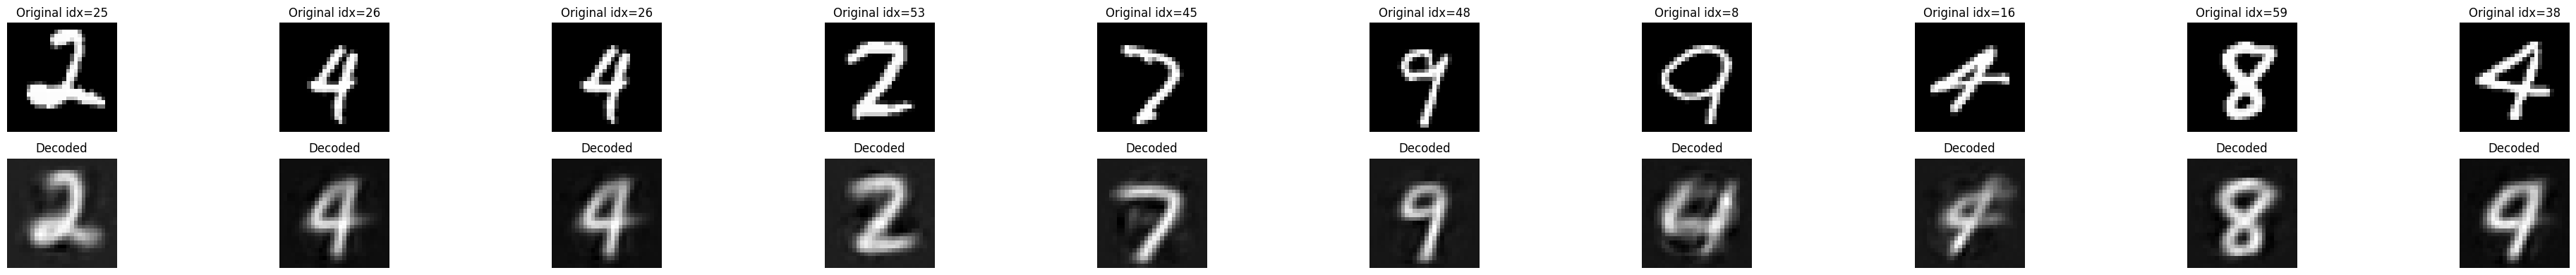

In [14]:
plot_original_vs_decoded(new_model, train_loader, device, num_samples=10)

### 10 features


In [61]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/MNIST/ld10_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0005
Epoch: 1/15, Average loss: 0.0004
Epoch: 2/15, Average loss: 0.0004
Epoch: 3/15, Average loss: 0.0004
Epoch: 4/15, Average loss: 0.0004
Epoch: 5/15, Average loss: 0.0004
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0003
Training completed. Final training loss: 0.0003496197787734369, Validation loss: 0.0003449242809787393
Epoch: 0/15, Average loss: 0.0004
Epoch: 1/15, Average loss: 0.0003
Epoch: 2/15, Average loss: 0.0003
Epoch: 3/15, Average loss: 0.0003
Epoch: 4/15, Average loss: 0.0003
Epoch: 5/15, Average loss: 0.0003
Epoch: 6/15, Average loss: 0.0003
Epoch: 7/15, Average loss: 0.0003
Epoch: 8/15, Average loss: 0.0003
Epoch: 9/15, Average loss: 0.0003
Epoch: 10/15, Average loss: 0.0003
Epoch: 

<All keys matched successfully>

## 2MNIST

In [63]:
train_loader = train_loader_2MNIST
val_loader = val_loader_2MNIST
input_dim = 784

### 6 features

In [43]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006649616351972024, Validation loss: 0.0006466862354427576
Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 

<All keys matched successfully>

In [50]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_1.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_1.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_1.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_1.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_1.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_1.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_1.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006561037523671985, Validation loss: 0.0006368833906948567
Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 

<All keys matched successfully>

In [57]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_1hl_2.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_2hl_2.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_2.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_4hl_2.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_5hl_2.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_6hl_2.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_2')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_2.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_7hl_2.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006576664683098594, Validation loss: 0.0006402463529258966
Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 

<All keys matched successfully>

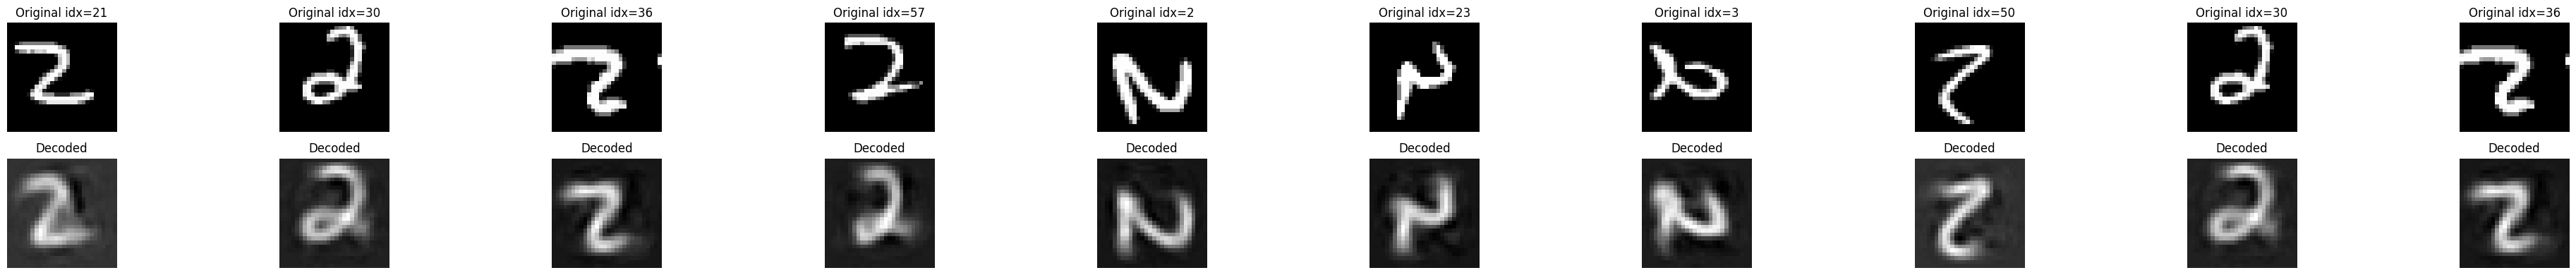

In [56]:
ex_model = AE_0(input_dim=input_dim, latent_dim=6, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld6_dr06_lr1e3_lwpretrain_3hl_1.pth', map_location=device))

plot_original_vs_decoded(ex_model, train_loader, device, num_samples=10, EMNIST=False)


### 8 features

In [ ]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_1hl.pth')

# 2 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_2hl.pth')

# 3 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_3hl.pth')

# 4 hidden layers
my_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.5, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl')
optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(my_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_ep15_dr05_lr1e3_opeSigm_4hl.pth')

#### lw pretrain

In [33]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=8, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld8_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld8_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0008
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0006
Epoch: 6/15, Average loss: 0.0006
Epoch: 7/15, Average loss: 0.0006
Epoch: 8/15, Average loss: 0.0006
Epoch: 9/15, Average loss: 0.0006
Epoch: 10/15, Average loss: 0.0006
Epoch: 11/15, Average loss: 0.0006
Epoch: 12/15, Average loss: 0.0006
Epoch: 13/15, Average loss: 0.0006
Epoch: 14/15, Average loss: 0.0006
Training completed. Final training loss: 0.0005826798321679234, Validation loss: 0.0005628092616796494
Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 

<All keys matched successfully>

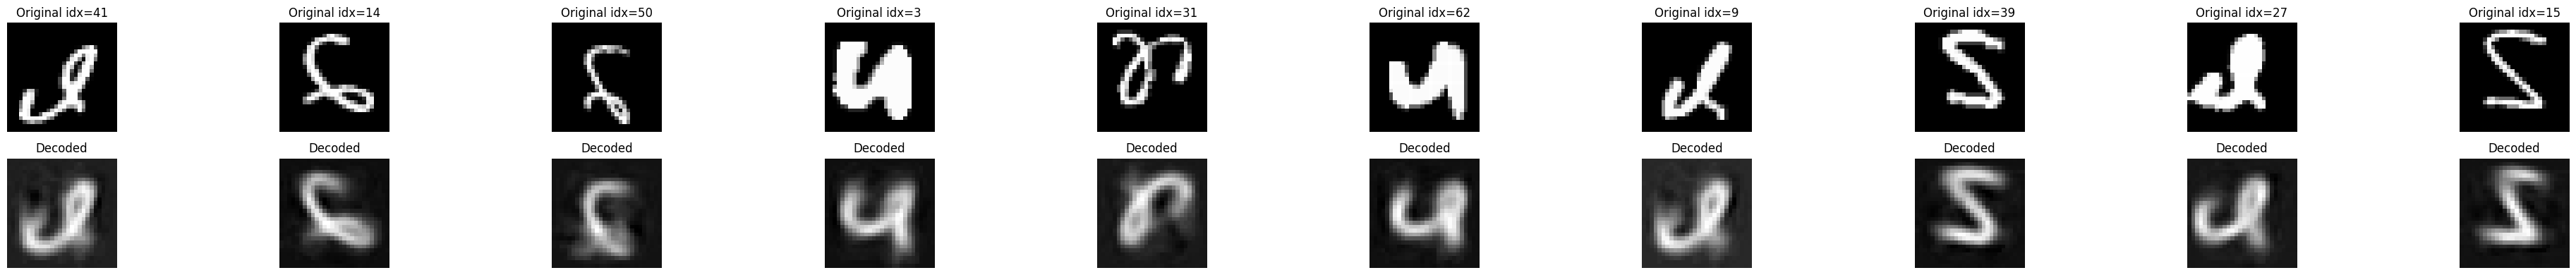

In [35]:
plot_original_vs_decoded(ex_model, train_loader, device, num_samples=10, EMNIST=True)

### 10 features


In [64]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 11/15, Average loss: 0.0005
Epoch: 12/15, Average loss: 0.0005
Epoch: 13/15, Average loss: 0.0005
Epoch: 14/15, Average loss: 0.0005
Training completed. Final training loss: 0.0005163868137945732, Validation loss: 0.0004988918887451291
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 

<All keys matched successfully>

In [65]:
learning_rate = 1e-3
weight_decay = 1e-5

# 1 hidden layer
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=1, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
ex_model.load_state_dict(new_model.state_dict())
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_1hl_1.pth', map_location=device))

# 2 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=2, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_2hl_1.pth', map_location=device))

# 3 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=3, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_3hl_1.pth', map_location=device))

# 4 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=4, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_4hl_1.pth', map_location=device))

# 5 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=5, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_5hl_1.pth', map_location=device))

# 6 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=6, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_6hl_1.pth', map_location=device))

# 7 hidden layers
new_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
layer_wise_pretrain_load_dict(ex_model, new_model)
ex_model = AE_0(input_dim=input_dim, latent_dim=10, decrease_rate=0.6, device=device, hidden_layers=7, output_activation_encoder=nn.Sigmoid, output_activation_decoder=None).to(device)
writer = SummaryWriter(log_dir='/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl_1')
optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
torch.save(new_model.state_dict(), '/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl_1.pth')
ex_model.load_state_dict(torch.load('/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/2MNIST/ld10_dr06_lr1e3_lwpretrain_7hl_1.pth', map_location=device))

Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15, Average loss: 0.0006
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0005
Epoch: 8/15, Average loss: 0.0005
Epoch: 9/15, Average loss: 0.0005
Epoch: 10/15, Average loss: 0.0005
Epoch: 11/15, Average loss: 0.0005
Epoch: 12/15, Average loss: 0.0005
Epoch: 13/15, Average loss: 0.0005
Epoch: 14/15, Average loss: 0.0005
Training completed. Final training loss: 0.0005152687742995719, Validation loss: 0.0004991521753370762
Epoch: 0/15, Average loss: 0.0006
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0005
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 

<All keys matched successfully>

# 2_M_E_MNIST

## simultaneous train

In [7]:

for latent_dim in (6, 8, 10):
    print(f"-----------------------Training models with {latent_dim} latent_dim----------------------\n")
    for num_hidden_layers in range(1,8):
        print(f"----------------- {num_hidden_layers} num_hidden_layers --------------")
        for dataset in ("MNIST", "EMNIST"):
            print(f"------------{dataset}------------")
            
            input_dim = 784
            learning_rate = 1e-3
            weight_decay = 1e-5
            decrease_rate = 0.6
            decrease_rate_str = "06"
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers=num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/simultaneous train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))
            writer_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/simultaneous train/2_M_E_MINST/ld{latent_dim}_dr{decrease_rate_str}_lr1e3_lwpretrain_{num_hidden_layers}hl.pth"
            writer = SummaryWriter(log_dir = writer_path)
            optimizer = optim.Adam(my_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(my_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
            torch.save(my_model.state_dict(), model_path)


-----------------------Training models with 6 latent_dim----------------------

----------------- 1 num_hidden_layers --------------
------------MNIST------------
Epoch: 0/15, Average loss: 0.0005
Epoch: 1/15, Average loss: 0.0005
Epoch: 2/15, Average loss: 0.0005
Epoch: 3/15, Average loss: 0.0005
Epoch: 4/15, Average loss: 0.0005
Epoch: 5/15, Average loss: 0.0005
Epoch: 6/15, Average loss: 0.0004
Epoch: 7/15, Average loss: 0.0004
Epoch: 8/15, Average loss: 0.0004
Epoch: 9/15, Average loss: 0.0004
Epoch: 10/15, Average loss: 0.0004
Epoch: 11/15, Average loss: 0.0004
Epoch: 12/15, Average loss: 0.0004
Epoch: 13/15, Average loss: 0.0004
Epoch: 14/15, Average loss: 0.0004
Training completed. Final training loss: 0.0004428318206531306, Validation loss: 0.00044095743726938966
------------EMNIST------------
Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0007
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Aver

## progressive train

In [4]:

for latent_dim in (6, 8, 10):
    print(f"-----------------------Training models with {latent_dim} latent_dim----------------------\n")
    for num_hidden_layers in range(1,8):
        print(f"----------------- {num_hidden_layers} num_hidden_layers --------------")
        for dataset in ("MNIST", "EMNIST"):
            print(f"------------{dataset}------------")
            
            input_dim = 784
            learning_rate = 1e-3
            weight_decay = 1e-5
            decrease_rate = 0.7
            epochs_for_each_neuron = 3
            train_loader = train_loaders[dataset]
            val_loader = val_loaders[dataset]
            input_dim = 28 * 28

            my_model = ProgressiveAE(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                num_hidden_layers=num_hidden_layers
            ).to(device)

            model_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/progressive train/2_M_E_MNIST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
            my_model.load_state_dict(torch.load(model_path, map_location=device))
            writer_path = f"/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/progressive train/2_M_E_MINST/ld{latent_dim}_dr{decrease_rate}_lr1e3_3epEach_keepTrain_{num_hidden_layers}hl.pth"
            writer = SummaryWriter(log_dir = writer_path)

            train_ProgressiveAE(
                my_model,
                epochs_for_each_neuron = 2,
                train_loader = train_loader,
                val_loader = val_loader,
                writer = writer,
                freeze_prev_neurons_train = False,
                mask_weights = False
            )

            torch.save(my_model.state_dict(), model_path)


-----------------------Training models with 6 latent_dim----------------------

----------------- 1 num_hidden_layers --------------
------------MNIST------------

-----------------------------TRAINING STARTED---------------------------- 

 ------------ Training of neuron1---------------
Epoch: 1/2, Average loss: 0.0006
Epoch: 2/2, Average loss: 0.0007
Training of neuron 1 completed. Final training loss: 0.0006927045747016867, Validation loss: 0.0007599017009139061

 ------------ Training of neuron2---------------
Epoch: 1/2, Average loss: 0.0008
Epoch: 2/2, Average loss: 0.0008
Training of neuron 2 completed. Final training loss: 0.0008131742510323724, Validation loss: 0.000806530949100852

 ------------ Training of neuron3---------------
Epoch: 1/2, Average loss: 0.0007
Epoch: 2/2, Average loss: 0.0007
Training of neuron 3 completed. Final training loss: 0.0006828688252717256, Validation loss: 0.0006799816485494375

 ------------ Training of neuron4---------------
Epoch: 1/2, Average

# Encoder output: ReLU

## Simultaneous

In [8]:

for dataset in ("2MNIST", "MNIST", "EMNIST"):
    print(f"\n\n\n------------{dataset}------------\n\n\n")

    input_dim = 784
    learning_rate = 1e-3
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28


    for latent_dim in (8,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=15)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/simultaneous train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNIST------------






-----------------------Training models with 8 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 0/15, Average loss: 0.0009
Epoch: 1/15, Average loss: 0.0008
Epoch: 2/15, Average loss: 0.0007
Epoch: 3/15, Average loss: 0.0007
Epoch: 4/15, Average loss: 0.0007
Epoch: 5/15, Average loss: 0.0007
Epoch: 6/15, Average loss: 0.0007
Epoch: 7/15, Average loss: 0.0007
Epoch: 8/15, Average loss: 0.0007
Epoch: 9/15, Average loss: 0.0007
Epoch: 10/15, Average loss: 0.0007
Epoch: 11/15, Average loss: 0.0007
Epoch: 12/15, Average loss: 0.0007
Epoch: 13/15, Average loss: 0.0007
Epoch: 14/15, Average loss: 0.0007
Training completed. Final training loss: 0.0006506609845906496, Validation loss: 0.000634459638595581


----------------- 2 num_hidden_layers --------------


Epoch: 0/15, Average loss: 0.0007
Epoch: 1/15, Average loss: 0.0006
Epoch: 2/15, Average loss: 0.0006
Epoch: 3/15, Average loss: 0.0006
Epoch: 4/15

## Progressive

In [13]:

for dataset in ("2MNIST", "MNIST", "EMNIST"):
    print(f"\n\n\n------------{dataset}------------\n\n\n")

    input_dim = 784
    learning_rate = 1e-3
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    epochs_for_each_neuron = 2

    for latent_dim in (8,):
        print(f"\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n")

        for num_hidden_layers in range(1, 7):
            print(f"\n-----------{num_hidden_layers} hidden layers ----------\n")


            if num_hidden_layers >= 4:
                epochs_for_each_neuron = 3
            else:
                epochs_for_each_neuron = 2
                
            my_model = ProgressiveAE(
                input_dim=input_dim,
                latent_dim=latent_dim,
                decrease_rate=decrease_rate,
                device=device,
                num_hidden_layers=num_hidden_layers,
                bottleneck_in_fn=nn.ReLU
            ).to(device)

            log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl'
            writer = SummaryWriter(log_dir=log_dir)

            train_ProgressiveAE(
                my_model,
                epochs_for_each_neuron = epochs_for_each_neuron,
                train_loader=train_loader,
                val_loader=val_loader,
                writer=writer,
                freeze_prev_neurons_train=False
            )

            model_path = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/progressive train/{dataset}/ld{latent_dim}_lr1e-3_dr{decrease_rate}_{num_hidden_layers}hl.pth'
            torch.save(my_model.state_dict(), model_path)




------------2MNIST------------





-----------------------Training models with 8 latent_dim----------------------



-----------1 hidden layers ----------


-----------------------------TRAINING STARTED---------------------------- 

 ------------ Training of neuron1---------------
Epoch: 1/2, Average loss: 0.0015
Epoch: 2/2, Average loss: 0.0014
Training of neuron 1 completed. Final training loss: 0.0014054635065297286, Validation loss: 0.0014129798971116542

 ------------ Training of neuron2---------------
Epoch: 1/2, Average loss: 0.0013
Epoch: 2/2, Average loss: 0.0013
Training of neuron 2 completed. Final training loss: 0.0012995138016839822, Validation loss: 0.0013128372371196747

 ------------ Training of neuron3---------------
Epoch: 1/2, Average loss: 0.0011
Epoch: 2/2, Average loss: 0.0010
Training of neuron 3 completed. Final training loss: 0.0010162217194214463, Validation loss: 0.0010010863922536373

 ------------ Training of neuron4---------------
Epoch: 1/2, Average l

# He init

## 6 features

### bias 0.1

In [26]:

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.1


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.1).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.1).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0011
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003908462950028479, Validation loss: 0.0003919352373108268


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0004
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Ave

In [31]:

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.1


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        for num_hidden_layers in (3,4):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            model_path = f"../models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers-1}hl.pth"
            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers-1, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(torch.load(model_path, map_location=device))

            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.1).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 3 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003949329761167367, Validation loss: 0.0003993710337206721


----------------- 4 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Ave

In [27]:

for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.5


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.1).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.1).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0013
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0006
Epoch: 8/10, Average loss: 0.0006
Epoch: 9/10, Average loss: 0.0006
Epoch: 10/10, Average loss: 0.0006
Training completed. Final training loss: 0.0006025245074341272, Validation loss: 0.0006041387462631819


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

### bias 0

In [45]:

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0
    train_num = 1


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        for num_hidden_layers in (3,5):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")

            ex_model_path = f'../models/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers-1}hl_{train_num}.pth'
            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers-1, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(torch.load(ex_model_path, map_location=device))

            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=0.2).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 3 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.00044647559182097514, Validation loss: 0.0004490873884409666


----------------- 5 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

#### MNIST

In [ ]:
# 0

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.00043625265415757895, Validation loss: 0.00043595574721693993


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, A

In [ ]:
# 1

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0004372881212582191, Validation loss: 0.0004384378997609019


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0004
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Ave

In [4]:
# 2

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.00043984282560025653, Validation loss: 0.0004394606212154031


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Av

In [21]:
# 3

for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003987126320290069, Validation loss: 0.0003965224679559469


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0004
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Ave

#### EMNIST

In [ ]:
# 0

for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006797049079645187, Validation loss: 0.000682065949795094


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Ave

In [ ]:
# 1
for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0007
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0006
Epoch: 8/10, Average loss: 0.0006
Epoch: 9/10, Average loss: 0.0006
Epoch: 10/10, Average loss: 0.0006
Training completed. Final training loss: 0.0006015755537672774, Validation loss: 0.0006041570079136403


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

In [6]:
# 2

for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006665498469064527, Validation loss: 0.0006681541658620885


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

KeyboardInterrupt: 

In [15]:

for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        for num_hidden_layers in (6,):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            ex_model_path = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers-1}hl_0.pth'
            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers-1, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(torch.load(ex_model_path, map_location=device))

            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_0')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_0.pth'
            torch.save(new_model.state_dict(), save_dir)




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 6 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0010
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0008
Epoch: 4/10, Average loss: 0.0008
Epoch: 5/10, Average loss: 0.0008
Epoch: 6/10, Average loss: 0.0008
Epoch: 7/10, Average loss: 0.0008
Epoch: 8/10, Average loss: 0.0008
Epoch: 9/10, Average loss: 0.0008
Epoch: 10/10, Average loss: 0.0008
Training completed. Final training loss: 0.0007501866016536951, Validation loss: 0.0007459733561870265


In [22]:
# 3

for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}features/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0010
Epoch: 2/10, Average loss: 0.0009
Epoch: 3/10, Average loss: 0.0008
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006792914878629835, Validation loss: 0.0006809322345764079


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

#### 2MNIST

In [ ]:
# 0

for dataset in ("2MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0010
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006617199646309018, Validation loss: 0.0006449983097612858


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0008
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0006
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

In [ ]:
# 1

for dataset in ("2MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_1.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0008
Epoch: 3/10, Average loss: 0.0008
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006663647266725699, Validation loss: 0.0006521976307034493


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

In [ ]:
# 2

for dataset in ("2MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,7):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/runs/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'/Users/enricofrausin/Programmazione/PythonProjects/Tesi/Autoencoders/models/relu_output/he init/simultaneous train/{dataset}/ld{latent_dim}_lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_2.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0010
Epoch: 2/10, Average loss: 0.0009
Epoch: 3/10, Average loss: 0.0008
Epoch: 4/10, Average loss: 0.0007
Epoch: 5/10, Average loss: 0.0007
Epoch: 6/10, Average loss: 0.0007
Epoch: 7/10, Average loss: 0.0007
Epoch: 8/10, Average loss: 0.0007
Epoch: 9/10, Average loss: 0.0007
Epoch: 10/10, Average loss: 0.0007
Training completed. Final training loss: 0.0006664422866577903, Validation loss: 0.0006476511012762784


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0008
Epoch: 2/10, Average loss: 0.0007
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0006
Epoch: 8/10, Average loss: 0.0006
Epoch: 9/10, Average loss: 0.0006
Epoch: 10/10, Av

In [27]:
# 3

for dataset in ("2MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 5e-4
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    input_dim = 28 * 28
    bias = 0.0


    for latent_dim in (6,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
        writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,4):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU, he_init=True, set_bias=bias).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/relu_output/he init/simultaneous train/{latent_dim}ld/{dataset}/lr{learning_rate}_dr{decrease_rate}_bias{bias}_{num_hidden_layers}hl_3.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.ReLU).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNIST------------




-----------------------Training models with 6 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0008
Epoch: 2/10, Average loss: 0.0007
Epoch: 3/10, Average loss: 0.0007
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0006
Epoch: 7/10, Average loss: 0.0006
Epoch: 8/10, Average loss: 0.0006
Epoch: 9/10, Average loss: 0.0006
Epoch: 10/10, Average loss: 0.0006
Training completed. Final training loss: 0.0005940342855950197, Validation loss: 0.0005799976237118244


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0006
Epoch: 4/10, Average loss: 0.0006
Epoch: 5/10, Average loss: 0.0006
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Av

KeyboardInterrupt: 

# Output func: Sigmoid

## Simultaneous

### 10 ld

In [ ]:
for dataset in ("2MNISTonly",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e-3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 0


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNISTonly------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003943694289617388, Validation loss: 0.0003999051504385795


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0003
Epoch: 9/10, Average loss: 0.0003
Epoch: 10/1

In [12]:
for dataset in ("2MNISTonly",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e-3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 1


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNISTonly------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003881844297706701, Validation loss: 0.0003936980388943077


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0003
Epoch: 9/10, Average loss: 0.0003
Epoch: 10/1

In [13]:
for dataset in ("2MNISTonly",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e-3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 2


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------2MNISTonly------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0009
Epoch: 2/10, Average loss: 0.0006
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003909928165813867, Validation loss: 0.00039278013205747733


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0007
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0003
Epoch: 9/10, Average loss: 0.0003
Epoch: 10/

In [14]:
for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 1


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0004
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.0003558810314474007, Validation loss: 0.00034992641527205705


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0004
Epoch: 2/10, Average loss: 0.0003
Epoch: 3/10, Average loss: 0.0003
Epoch: 4/10, Average loss: 0.0003
Epoch: 5/10, Average loss: 0.0003
Epoch: 6/10, Average loss: 0.0003
Epoch: 7/10, Average loss: 0.0003
Epoch: 8/10, Average loss: 0.0003
Epoch: 9/10, Average loss: 0.0003
Epoch: 10/10, A

In [15]:
for dataset in ("MNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 2


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------MNIST------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0005
Epoch: 2/10, Average loss: 0.0004
Epoch: 3/10, Average loss: 0.0004
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, Average loss: 0.0004
Training completed. Final training loss: 0.00035711239244168004, Validation loss: 0.00035173319336026906


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0004
Epoch: 2/10, Average loss: 0.0003
Epoch: 3/10, Average loss: 0.0003
Epoch: 4/10, Average loss: 0.0003
Epoch: 5/10, Average loss: 0.0003
Epoch: 6/10, Average loss: 0.0003
Epoch: 7/10, Average loss: 0.0003
Epoch: 8/10, Average loss: 0.0003
Epoch: 9/10, Average loss: 0.0003
Epoch: 10/10, 

In [16]:
for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 1


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Average loss: 0.0005
Training completed. Final training loss: 0.0004918764829173262, Validation loss: 0.0004920146085242642


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, A

In [17]:
for dataset in ("EMNIST",):
    print(f"\n\n\n------------{dataset}------------\n")

    input_dim = 784
    learning_rate = 1e-3
    learning_rate_str = "1e3"
    decrease_rate_str = "06"
    weight_decay = 1e-5
    decrease_rate = 0.6
    train_loader = train_loaders[dataset]
    val_loader = val_loaders[dataset]
    train_num = 2


    for latent_dim in (10,):
        print(f"\n\n\n-----------------------Training models with {latent_dim} latent_dim----------------------\n\n\n")

        num_hidden_layers = 1

        print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
        
        new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
        writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
        optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
        save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
        torch.save(new_model.state_dict(), save_dir)

        ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
        ex_model.load_state_dict(new_model.state_dict())

        for num_hidden_layers in range(2,8):
            print(f"\n\n----------------- {num_hidden_layers} num_hidden_layers --------------\n\n")
            
            new_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid, he_init=False).to(device)
            layer_wise_pretrain_load_dict(ex_model, new_model)

            writer = SummaryWriter(log_dir=f'../runs/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}')
            optimizer = optim.Adam(new_model.parameters(), lr=learning_rate, weight_decay=weight_decay)
            train(new_model, writer=writer, train_loader=train_loader, val_loader=val_loader, optimizer=optimizer, epochs=10)
            save_dir = f'../models/sigmoid_output/simultaneous train/{latent_dim}ld/{dataset}/dr{decrease_rate_str}_lr{learning_rate_str}_lwpretrain_{num_hidden_layers}hl_{train_num}.pth'
            torch.save(new_model.state_dict(), save_dir)

            ex_model = AE_0(input_dim=input_dim, latent_dim=latent_dim, decrease_rate=decrease_rate, device=device, hidden_layers = num_hidden_layers, output_activation_encoder=nn.Sigmoid).to(device)
            ex_model.load_state_dict(new_model.state_dict())




------------EMNIST------------




-----------------------Training models with 10 latent_dim----------------------





----------------- 1 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0005
Epoch: 5/10, Average loss: 0.0005
Epoch: 6/10, Average loss: 0.0005
Epoch: 7/10, Average loss: 0.0005
Epoch: 8/10, Average loss: 0.0005
Epoch: 9/10, Average loss: 0.0005
Epoch: 10/10, Average loss: 0.0005
Training completed. Final training loss: 0.0004909833188413094, Validation loss: 0.0004930691677641044


----------------- 2 num_hidden_layers --------------


Epoch: 1/10, Average loss: 0.0006
Epoch: 2/10, Average loss: 0.0005
Epoch: 3/10, Average loss: 0.0005
Epoch: 4/10, Average loss: 0.0004
Epoch: 5/10, Average loss: 0.0004
Epoch: 6/10, Average loss: 0.0004
Epoch: 7/10, Average loss: 0.0004
Epoch: 8/10, Average loss: 0.0004
Epoch: 9/10, Average loss: 0.0004
Epoch: 10/10, A